In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#transfer learning
from tensorflow.keras.applications.resnet50 import ResNet50


#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2024-04-13 11:14:09.895961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 11:14:11.452081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


In [2]:
input_shape_2D=(250,250)
input_shape_3D= (250,250,3)
seeds=42
batch_size=32
epochs=10
stopper=EarlyStopping(patience=5)

In [3]:
#loading image data
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory='data/RiceLeafsDisease/train',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seeds
)

Found 2100 files belonging to 6 classes.


2024-04-13 11:14:20.764908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 11:14:20.888199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 11:14:20.888699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
valid_ds= tf.keras.utils.image_dataset_from_directory(
    directory='data/RiceLeafsDisease/validation',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seeds
)

Found 528 files belonging to 6 classes.


In [5]:
#class labels
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


In [7]:
X=[]
y= []

for image, label in data_ds.batch(199):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())

In [8]:
# converting to numpy array
X= np.array(X)
y= np.array(y)

In [9]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seeds)

In [10]:
X_train = X_train/255
X_test = X_test/255

In [11]:
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (1680, 250, 250, 3)
shape of y_train: (1680,)
shape of X_test_scaled: (420, 250, 250, 3)
shape of y_test: (420,)


In [12]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

In [13]:
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(250,250,3))

for layer in resnet50.layers:
    layer.trainable=False

resnet_model = Sequential()
resnet_model.add(resnet50)
resnet_model.add(BatchNormalization())
resnet_model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.5))
resnet_model.add(Dense(2048, activation='relu'))
# model.add(Dropout(0.5))
resnet_model.add(Dense(6, activation='softmax'))
resnet_model.summary()

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization (Batch  (None, 8, 8, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                         

In [15]:
import time
# Record the start time of training
start_time = time.time()

In [16]:
resnet_history=resnet_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/10


2024-04-13 11:15:54.400103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-13 11:15:58.683547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-13 11:16:00.255073: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x30446ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 11:16:00.255339: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-13 11:16:00.423170: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 11:16:01.134578: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

53/53 [==============================] - 21s 150ms/step - loss: 1.1645 - accuracy: 0.5589 - val_loss: 4.6486 - val_accuracy: 0.2405
Epoch 2/10
53/53 [==============================] - 5s 98ms/step - loss: 0.8485 - accuracy: 0.6946 - val_loss: 3.5692 - val_accuracy: 0.2548
Epoch 3/10
53/53 [==============================] - 6s 105ms/step - loss: 0.7098 - accuracy: 0.7345 - val_loss: 2.3482 - val_accuracy: 0.3119
Epoch 4/10
53/53 [==============================] - 5s 100ms/step - loss: 0.5898 - accuracy: 0.7798 - val_loss: 1.9029 - val_accuracy: 0.4095
Epoch 5/10
53/53 [==============================] - 5s 100ms/step - loss: 0.5258 - accuracy: 0.8048 - val_loss: 1.2058 - val_accuracy: 0.5214
Epoch 6/10
53/53 [==============================] - 5s 100ms/step - loss: 0.4770 - accuracy: 0.8292 - val_loss: 1.0923 - val_accuracy: 0.5357
Epoch 7/10
53/53 [==============================] - 5s 99ms/step - loss: 0.4619 - accuracy: 0.8196 - val_loss: 0.6901 - val_accuracy: 0.7452
Epoch 8/10
53/53 [

In [17]:
# Record the training end time
end_time = time.time()

In [18]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 89.00208306312561 seconds


In [19]:
pd.DataFrame(resnet_history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.164508,0.558929,4.648638,0.240476
1,0.848463,0.694643,3.569174,0.254762
2,0.709789,0.734524,2.348151,0.311905
3,0.589765,0.779762,1.902900,0.409524
4,0.525815,0.804762,1.205755,0.521429
5,0.476978,0.829167,1.092324,0.535714
6,0.461879,0.819643,0.690053,0.745238
7,0.395863,0.865476,0.741706,0.707143
8,0.353375,0.875595,0.635025,0.752381
9,0.321666,0.888690,0.638003,0.778571


In [20]:
import joblib

joblib.dump(resnet_history.history,'history_ResNet50.pkl')
history = joblib.load('history_ResNet50.pkl')

In [21]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

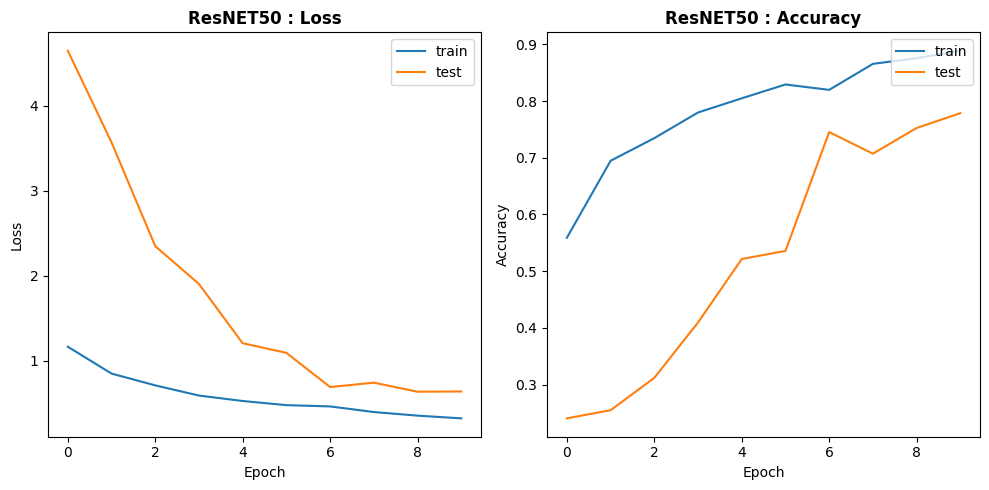

In [22]:
plot_performance(model_name='ResNET50',
                acc=resnet_history.history['accuracy'], 
                 val_acc=resnet_history.history['val_accuracy'],
                 loss=resnet_history.history['loss'], 
                 val_loss=resnet_history.history['val_loss'])

In [23]:
resnet_model.save('ResNet50_model.h5')

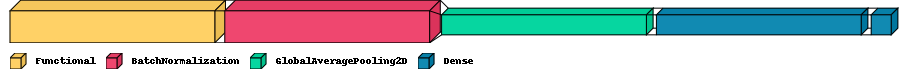

In [24]:
import visualkeras

visualkeras.layered_view(resnet_model,  legend=True)